In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")

/tmp/ipykernel_35679/2370551333.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Input/pesticide_use.csv", encoding = "cp1252")


# Choice of unit = gram per International Dollar

In [3]:
df = df[df["Unit"] == "g/Int$"]

# Mean and Variance of g/Int$

In [4]:
continents_to_filter = ['Africa', 'Asia', 'Europe', 'Northern America', 'Central America', 'South America', 'Oceania']
filtered_df = df[df['Area'].isin(continents_to_filter)]

In [5]:
grouped_stats = filtered_df.groupby('Area')['Value'].agg(['mean', 'std'])
grouped_stats

,mean,std
Area,,
Africa,0.428438,0.063860
Asia,0.594688,0.065795
Central America,1.210000,0.181659
Europe,0.918750,0.049693
Northern America,1.332812,0.118872
Oceania,0.830000,0.186496
South America,1.707812,0.613976


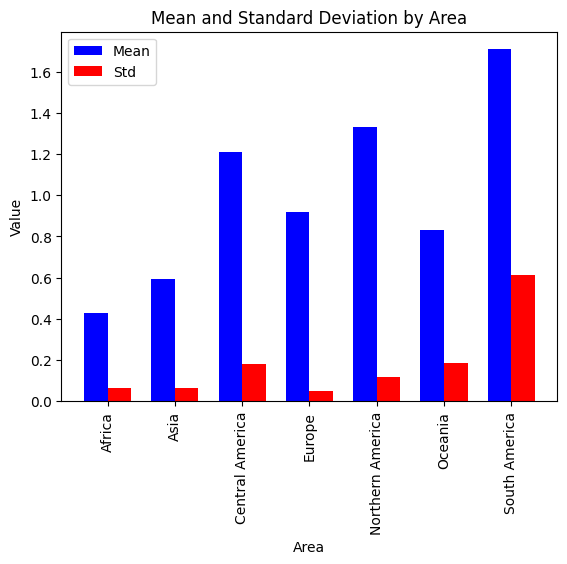

In [6]:
import matplotlib.pyplot as plt
df = grouped_stats

# Plotting grouped bar chart
fig, ax = plt.subplots()

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x = range(len(df))

# Plotting bars for mean
bars1 = ax.bar(x, df['mean'], width=bar_width, label='Mean', color='b')

# Plotting bars for standard deviation
bars2 = ax.bar([p + bar_width for p in x], df['std'], width=bar_width, label='Std', color='r')

# Labeling the x-axis ticks with area names
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(df.index, rotation=90)

# Adding labels, title, and legend
ax.set_xlabel('Area')
ax.set_ylabel('Value')
ax.set_title('Mean and Standard Deviation by Area')
ax.legend()

# Show the plot
plt.show()

# Trend analysis of 7 regions (1990-2021)

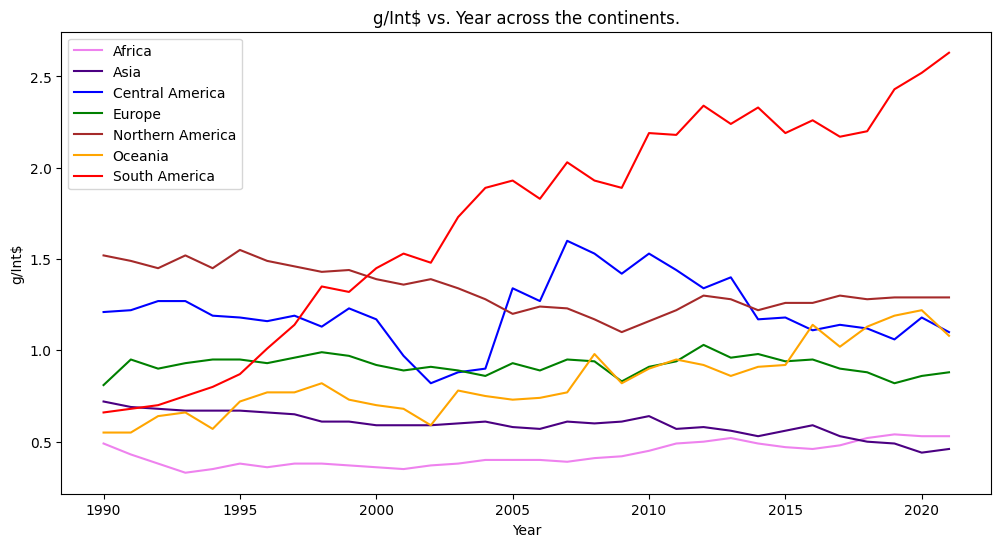

In [7]:
import matplotlib.pyplot as plt
groupedseries = filtered_df.groupby('Area')
listofdfs = [group for _, group in groupedseries]
colors = ['violet','indigo','blue','green','brown','orange','red']
plt.figure(figsize=[12,6])
for i in range(len(listofdfs)):
    temp = listofdfs[i]
    label = temp['Area'].unique()[0]
    plt.plot(
        temp['Year'],
        temp['Value'],
        marker = None,
        linestyle = '-',
        color = colors[i],
        label =label
    )
plt.xlabel('Year')
plt.ylabel('g/Int$')
plt.title('g/Int$ vs. Year across the continents.')
plt.legend()
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

# Step 1: check for stationarity of time-series

## Method 1: time series plot

In [9]:
traindfs = []
testdfs = []
for i in range(len(listofdfs)):
    traindfs.append(listofdfs[i].head(len(listofdfs[i])-1))
    testdfs.append(listofdfs[i].tail(1))

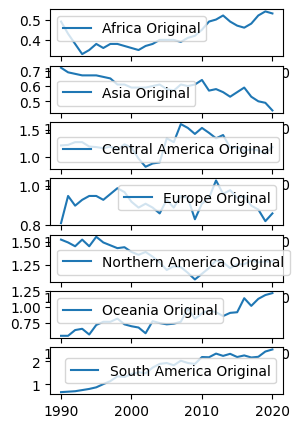

In [10]:
fig, axs = plt.subplots(len(listofdfs),1, figsize=(3,5))
for i in range(len(listofdfs)):
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    axs[i].plot(temp['Year'], temp['Value'], label = label +" "+ "Original")
    axs[i].legend()

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Method 3: ADF test

In [12]:
# The null hypothesis in the ADF test is: the time series is non-stationary
# If p < 0.5 we reject the null == the time series is non-stationary
# Let us see if we reject the null for all the seven time-series

In [13]:
from statsmodels.tsa.stattools import adfuller
for i in range(len(traindfs)): 
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    adf_test = adfuller(temp["Value"])
    print("p-value = "+str(adf_test[1]) + " for "+label)

p-value = 0.22387709578732895 for Africa
p-value = 0.8808034257898254 for Asia
p-value = 0.0451662891591232 for Central America
p-value = 0.0016448342414842848 for Europe
p-value = 0.44787654126717014 for Northern America
p-value = 0.9977472938234591 for Oceania
p-value = 0.06341469876717186 for South America


In [14]:
# if p-value < 0.5 continue with modeling
continuewithmodeling = [0, 0, 1, 1, 0, 0, 0]

In [15]:
def find_d(timeseries, p_value):
    p = adfuller(timeseries)[1]
    if p < p_value:
        return 0
    return 1 + find_d(timeseries.diff().dropna(), p_value)

In [30]:
num_diffs = []
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    number_of_differencing = find_d(traindfs[i]["Value"], 0.05)
    print("Run differencing "+str(number_of_differencing)+" times for "+area)
    num_diffs.append(number_of_differencing)

Run differencing 2 times for Africa
Run differencing 2 times for Asia
Run differencing 0 times for Central America
Run differencing 0 times for Europe
Run differencing 1 times for Northern America
Run differencing 1 times for Oceania
Run differencing 1 times for South America


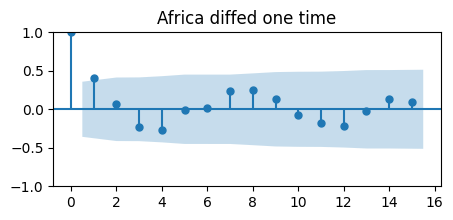

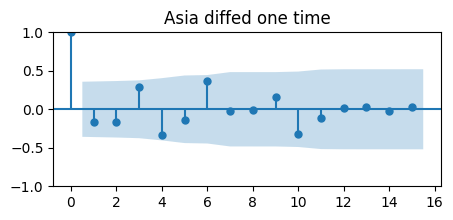

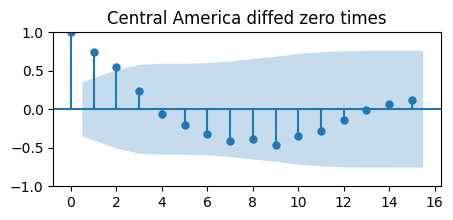

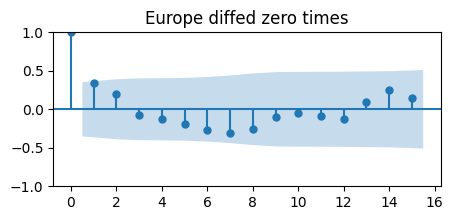

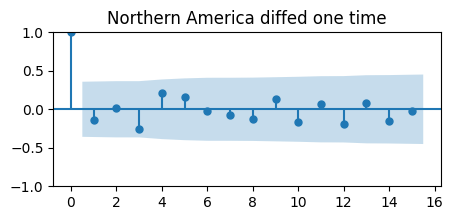

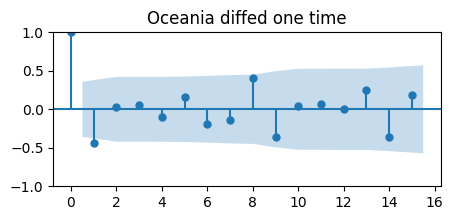

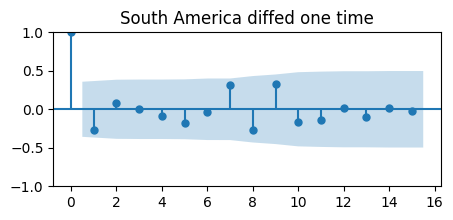

In [34]:
# the acf values drops really quickly, meaning the time series is less correlated with its lag
for i in range(len(traindfs)):
    fig, ax = plt.subplots(figsize=(5,2)) 
    temp = traindfs[i]
    label = temp['Area'].unique()[0]
    timeseries = traindfs[i]["Value"]
#     x = 0
#     while(x<num_diffs[i]):
#         timeseries = timeseries.diff().dropna()
#         x += 1
    if num_diffs[i] == 0:
        plot_acf(timeseries, ax=ax, title=label+" diffed zero times")
    else:
        timeseries = timeseries.diff().dropna()
        plot_acf(timeseries, ax=ax, title=label+" diffed one time")

In [35]:
# the final value of d according to the combinated of adf test and acf values
# d = [1, 1, 1, 0, 1, 1, 1 ]

In [36]:
d = [1, 1, 1, 0, 1, 1, 1 ]

# Determine the p and q values for the arima model

In [37]:
# we will look at the d list and do the diff accordingly and pass the time
# series into csv files and next run the r script
# finally we will look at the acf and pacf plot to decide on the p and q values

In [41]:
for i in range(len(traindfs)):
    area = traindfs[i]["Area"].unique()[0]
    timeseries = traindfs[i]["Value"]
    if d[i] == 1:
        timeseries =  timeseries.diff().dropna()
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv("./Input/"+area+".csv")

In [57]:
# look at the first slide of the downloaded slides
# In the acf chart there are a few significant spikes at the beginning, but it decreases to zero line in the middle, in the pacf chart you see only one or two spikes you use the ar model. The order in the ar(k) model depends on the number significant spikes in the pacf plot. In the above plot, for the first reason we will use n ar(k) model. the value of k = 1, since there is only one significant spike in the PACF plot.

In [58]:
# If the partial autocorrelation is significant at lag k and not sigbificant at any higher order lags
# i.e., PACF cuts off at lag k, then it suggests that you should try fitting an autoregressive model
# of order k.

In [59]:
newtimeseries[6]

102853   -0.415515
102854   -0.385662
102855   -0.356675
102856   -0.287682
102857   -0.223144
102858   -0.139262
102859    0.009950
102860    0.131028
102861    0.300105
102862    0.277632
102863    0.371564
102864    0.425268
102865    0.392042
102866    0.548121
102867    0.636577
102868    0.657520
102869    0.604316
102870    0.708036
102871    0.657520
102872    0.636577
102873    0.783902
102874    0.779325
102875    0.850151
102876    0.806476
102877    0.845868
102878    0.783902
102879    0.815365
102880    0.774727
102881    0.788457
102882    0.887891
102883    0.924259
Name: Logvalue, dtype: float64

In [60]:
for i in range(len(newtimeseries)):
    timeseries = newtimeseries[i]
    data = {"y":timeseries}
    temp = pd.DataFrame(data)
    temp.to_csv(areas[i]+".csv")

In [61]:
# africa arma(0,0)
# asia arma(2,3) or ma(3)
# central america ar(4)
# europe arma(0,0)
# northern america arma(0,0)
# oceanina arma(1,1)
# south america ar(1)

In [62]:
africa = traindfs[0]["Value"]

In [63]:
from statsmodels.tsa.arima.model import ARIMA

In [64]:
model = ARIMA(africa, order = (0,2,0))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [65]:
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   31
Model:                 ARIMA(0, 2, 0)   Log Likelihood                  65.069
Date:                Fri, 23 Aug 2024   AIC                           -128.137
Time:                        09:27:32   BIC                           -126.770
Sample:                             0   HQIC                          -127.709
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0007      0.000      4.258      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 0.39
Prob(Q):                              0.22   Pr

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


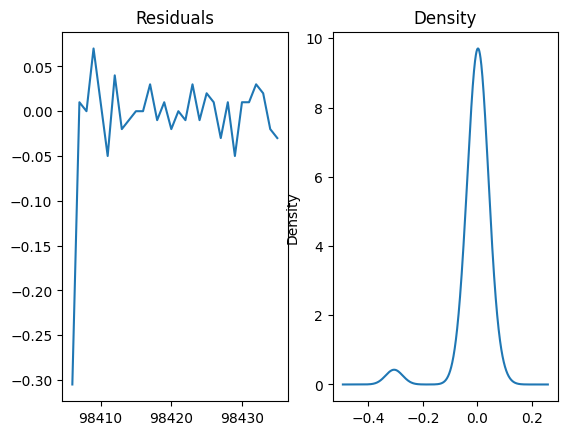

In [66]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = "kde", ax = ax[1])
plt.show()

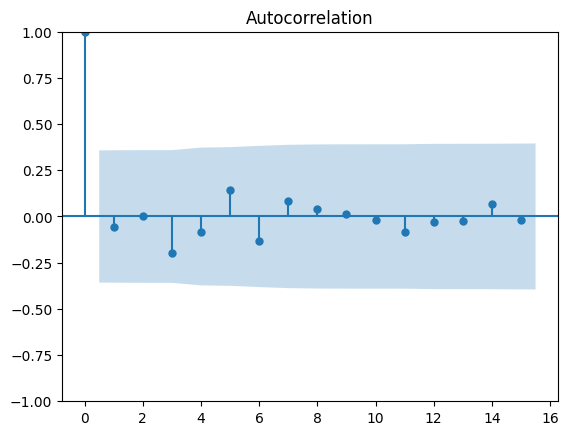

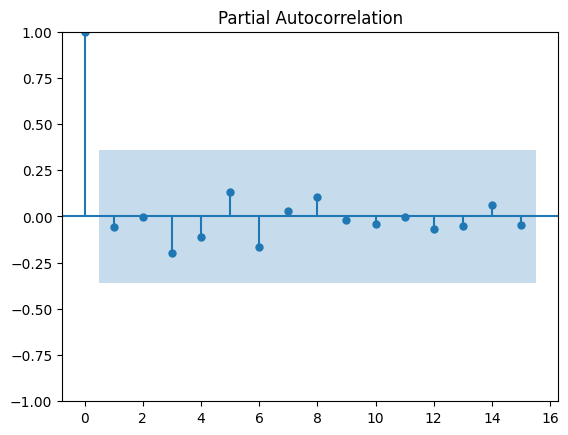

In [67]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

In [68]:
africa_test = testdfs[0]["Value"]

In [69]:
forecast_test = model_fit.forecast(len(africa_test))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [70]:
forecast_test

31    0.52
dtype: float64

In [71]:
x = pd.DataFrame()

In [72]:
x["forecast_manual"] = [None]*len(africa)+list(forecast_test)

In [73]:
traindfs[0]

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,Logvalue
98405,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1990,1990,g/Int$,0.49,E,NaN,-0.713350
98406,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1991,1991,g/Int$,0.43,E,NaN,-0.843970
98407,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1992,1992,g/Int$,0.38,E,NaN,-0.967584
98408,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1993,1993,g/Int$,0.33,E,NaN,-1.108663
98409,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1994,1994,g/Int$,0.35,E,NaN,-1.049822
98410,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1995,1995,g/Int$,0.38,E,NaN,-0.967584
98411,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1996,1996,g/Int$,0.36,E,NaN,-1.021651
98412,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1997,1997,g/Int$,0.38,E,NaN,-0.967584
98413,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1998,1998,g/Int$,0.38,E,NaN,-0.967584
98414,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1999,1999,g/Int$,0.37,E,NaN,-0.994252


In [74]:
import pmdarima as pm

In [75]:
auto_arima = pm.auto_arima(africa, stepwise=False, seasonal=False)

In [76]:
auto_arima

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [77]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  70.988
Date:                Fri, 23 Aug 2024   AIC                           -135.976
Time:                        09:27:34   BIC                           -131.773
Sample:                             0   HQIC                          -134.631
                                 - 31                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.004     -0.111      0.912      -0.008       0.007
ar.L1          0.4915      0.149      3.300      0.001       0.200       0.783
sigma2         0.0005      0.000      3.188      0.001       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.86   Prob(JB):                         0.77
Heteroskedasticity (H):               0.54   Skew:                            -0.24
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
forecast_test_auto = auto_arima.predict(n_periods=len(africa_test))

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [79]:
forecast_test_auto

31    0.52464
dtype: float64

In [80]:
auto_arima.params

<bound method ARIMA.params of ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)>

In [81]:
traindfs[0]

,Area Code,Area Code (M49),Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,Logvalue
98405,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1990,1990,g/Int$,0.49,E,NaN,-0.713350
98406,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1991,1991,g/Int$,0.43,E,NaN,-0.843970
98407,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1992,1992,g/Int$,0.38,E,NaN,-0.967584
98408,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1993,1993,g/Int$,0.33,E,NaN,-1.108663
98409,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1994,1994,g/Int$,0.35,E,NaN,-1.049822
98410,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1995,1995,g/Int$,0.38,E,NaN,-0.967584
98411,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1996,1996,g/Int$,0.36,E,NaN,-1.021651
98412,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1997,1997,g/Int$,0.38,E,NaN,-0.967584
98413,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1998,1998,g/Int$,0.38,E,NaN,-0.967584
98414,5100,'002,Africa,1357,Pesticides (total),5173,Use per value of agricultural production,1999,1999,g/Int$,0.37,E,NaN,-0.994252


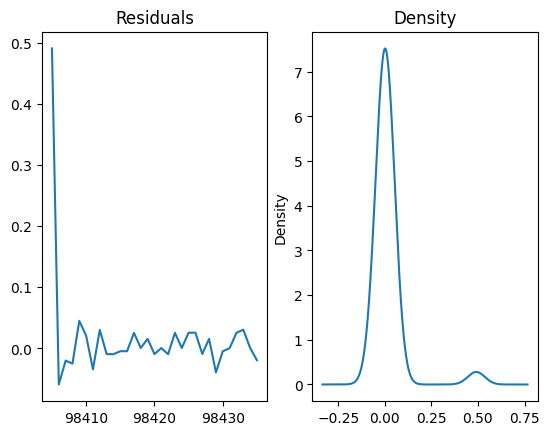

In [82]:
import matplotlib.pyplot as plt
residuals = auto_arima.resid()
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(title = "Density", kind = "kde", ax = ax[1])
plt.show()

In [83]:
# work with the africa timeseries

In [84]:
africa = traindfs[0]["Value"]

In [85]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 0.22387709578732895


In [86]:
africa = africa.diff().dropna()

In [87]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 0.1381247898044516


In [88]:
africa = africa.diff().dropna()

In [89]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(africa)
print(f'p-value: {adf_test[1]}')

p-value: 1.656901873452554e-05


In [90]:
ps = [0,2,4,0,0,1,1] 
ds = [2,2,1,0,1,1,0]
qs = [0,3,0,0,0,1,0]

In [92]:
for i in range(len(testdfs)):
    print(testdfs[i]["Value"])

98436    0.53
Name: Value, dtype: float64
103332    0.46
Name: Value, dtype: float64
101988    1.1
Name: Value, dtype: float64
105772    0.88
Name: Value, dtype: float64
101540    1.29
Name: Value, dtype: float64
107980    1.08
Name: Value, dtype: float64
102884    2.63
Name: Value, dtype: float64


In [94]:
from statsmodels.tsa.arima.model import ARIMA

In [96]:
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    model = ARIMA(continent, order = (ps[i],ds[i],qs[i]))
    model_fit = model.fit()
    continent_test = testdfs[i]["Value"]
    forecast_test = model_fit.forecast(len(continent_test))
    print(forecast_test)

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is av

31    0.52
dtype: float64
31    0.445063
dtype: float64
31    1.133447
dtype: float64
31    0.919995
dtype: float64
31    1.29
dtype: float64
31    1.205934
dtype: float64
31    2.509555
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [97]:
for i in range(len(ps)):
    continent = traindfs[i]["Value"]
    continent_test = testdfs[i]["Value"]
    auto_arima = pm.auto_arima(continent, stepwise=False, seasonal=False)
    forecast_test_auto = auto_arima.predict(n_periods=len(continent_test))
    print(forecast_test_auto)

/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.52464
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.455546
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.106139
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    0.85526
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.282333
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


31    1.216436
dtype: float64
31    2.574635
dtype: float64


/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/taufiq/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
